In [ ]:
import pandas as pd
import numpy as np
import math
import os
import json
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline


In [ ]:
columns =['userid','productid','ratings','timestamp']
df =pd.read_csv('ratings_Electronics (1).csv' , names=columns)
df.drop('timestamp',axis=1,inplace=True)
df.head()

,userid,productid,ratings
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [ ]:
df.describe()

,ratings
count,721191.000000
mean,3.977192
std,1.397653
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


In [ ]:
df1=df.iloc[:100005,0:]
df1.shape

(100005, 3)

In [ ]:
df1.isnull().sum()

userid       0
productid    0
ratings      0
dtype: int64

In [ ]:
# with sns.axes_style('dark'):
#     g = sns.factorplot("ratings", data=df1, aspect=1.0,kind='count')
#     g.set_ylabels("Total number of ratings")

In [ ]:
rating_byuser =df1.groupby(by='userid')['ratings'].count().sort_values(ascending=False)[:15]
print('Top 10 user based on ratings: \n', rating_byuser)

Top 10 user based on ratings: 
 userid
A231WM2Z2JL0U3    103
A2BGZ52M908MJY     50
AY8Q1X7G96HV5      37
A1MJMYLRTZ76ZX     34
A1NVD0TKNS1GT5     30
A7Y6AVS576M03      30
A1RPTVW5VEOSI      30
A3MEIR72XKQY88     27
ALUNVOQRXOZIA      26
A243HY69GIAHFI     25
A23ZO1BVFFLGHO     24
AN30G4IKL1BMZ      23
A6FIAB28IS79       23
A2B7BUH8834Y6M     22
A2G2QNKDL1Y6AC     21
Name: ratings, dtype: int64


In [ ]:
new_df=df1.groupby("productid").filter(lambda x:x['ratings'].count() >=50)

In [ ]:
new_df.shape

(60717, 3)

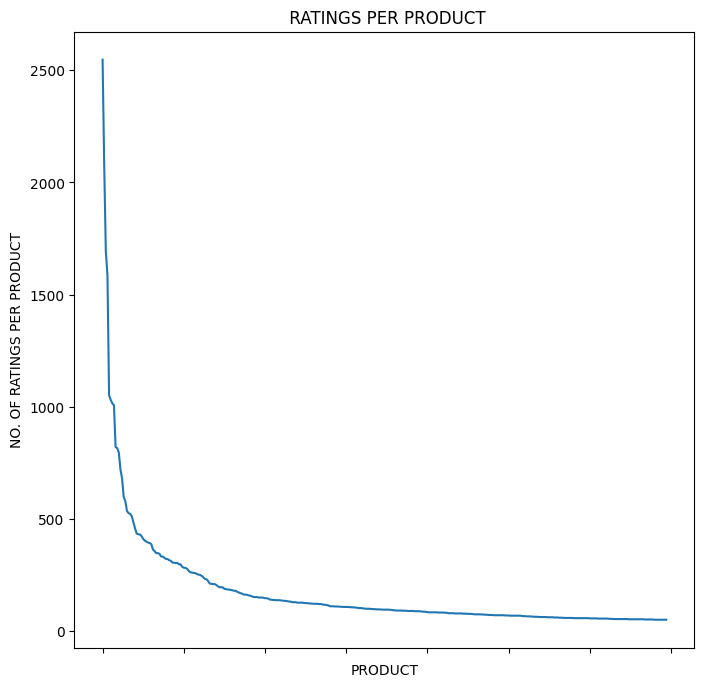

In [ ]:
no_of_ratings_per_product = new_df.groupby(by='productid')['ratings'].count().sort_values(ascending=False)
plt.figure(figsize=(8,8))
ax =plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title(' RATINGS PER PRODUCT')
plt.xlabel('PRODUCT')
plt.ylabel('NO. OF RATINGS PER PRODUCT')
ax.set_xticklabels([])
plt.show()

In [ ]:
new_df1 =new_df.head(10000)
rating_matrix =new_df1.pivot_table(values = 'ratings', index='userid' , columns='productid', fill_value=0)
rating_matrix.head()

productid,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
userid,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
print('Shape of the pivot table: ', rating_matrix.shape)

Shape of the pivot table:  (9832, 76)


Create model

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3096328 sha256=25ece8cb85d2c523f5e1fd7c681615abed9cb5c35ce51b7e172e675ec401ba7b
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

In [ ]:
reader =Reader(rating_scale=(1,5))
data =Dataset.load_from_df(new_df,reader)

In [ ]:
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)
test_pred = algo.test(testset)
test_pred

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


[Prediction(uid='A1H8GT7I9M0WGL', iid='B00004ZC8Y', r_ui=4.0, est=4.112891461377379, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A1AHL90POX6J9K', iid='B00000K2YR', r_ui=2.0, est=4.112891461377379, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AGHOXVI6REZBV', iid='B00005A1K1', r_ui=1.0, est=4.112891461377379, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A24UFW3NB8U7TH', iid='B00005ARK3', r_ui=5.0, est=4.112891461377379, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A1U27KEQJLR310', iid='B00000J4FS', r_ui=5.0, est=4.112891461377379, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A1SE5HUEEFUGYQ', iid='B00004ZCJE', r_ui=4.0, est=4.112891461377379, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A352KZOWEKJW

In [ ]:
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.2954


1.295357723541808

Collabarative Filtering(model-based)

In [ ]:
from sklearn.decomposition import TruncatedSVD
SVD =TruncatedSVD(n_components=15)
X=rating_matrix
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(9832, 15)

In [ ]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(9832, 9832)

In [ ]:
# finding co-relation between each product
correlation_product_ID = correlation_matrix[75]
correlation_product_ID.shape

(9832,)

In [ ]:
i=X.index[75]
i

'A10VA2FBKWP7A6'

In [ ]:
Recommend = list(X.index[correlation_product_ID > 0.6])
Recommend.remove(i)
Recommend[0:15]

['A0590501PZ7HOWJKBGQ4',
 'A099626739FNCRNHIKBCG',
 'A1003EYWAQFOUG',
 'A103XY7DJYZHFN',
 'A10CVZORIHLPC0',
 'A10D6JE3EV2KUR',
 'A10ELELHBVLYJJ',
 'A10G37KYLB8H3E',
 'A10MH3OBX7DBEY',
 'A10NBGOUJOAJ4U',
 'A10OJS6YZNT0L6',
 'A10T4K3FUXNDRU',
 'A10ZDC295HQWJU',
 'A111VR0F3ZVYHO',
 'A114RX6H6RDR74']